In [41]:
import matplotlib.pyplot
import numpy
import pandas
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import matplotlib.pyplot as plt
%pylab inline

seaborn.set_style('whitegrid')

database_df = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz")

database_df = (database_df.drop(['Record ID', 'Agency Code', 'Victim Ethnicity', 'Perpetrator Ethnicity',
                                 'Record Source'], axis=1))

Victim_Sex = database_df['Victim Sex'].values
Victim_Age = database_df['Victim Age'].values
# Victim_Age = Victim_Age.astype('int16')
Perpetrator_Sex = database_df['Perpetrator Sex'].values
Perpetrator_Age = database_df['Perpetrator Age'].values
# Perpetrator_Age = Perpetrator_Age.astype('int16')
Relationship = database_df['Relationship'].values
Weapon = database_df['Weapon'].values
Solved = database_df['Crime Solved'].values
V_Race = database_df['Victim Race'].values
P_Race = database_df['Perpetrator Race'].values
Crime_Type = database_df['Crime Type'].values
Agency_Name = database_df['Agency Name'].values
Agency_Type = database_df['Agency Type'].values
P_Count = database_df['Perpetrator Count'].values
City = database_df['City'].values
State = database_df['State'].values
Year = database_df['Year'].values
Month = database_df['Month'].values
Rel_Category = database_df['Relationship'].values
W_Category = database_df['Weapon'].values

homicide = pandas.DataFrame(numpy.column_stack((Victim_Sex, Victim_Age, Perpetrator_Sex, Perpetrator_Age,
                                                Relationship, Weapon, Solved, V_Race, P_Race, Crime_Type, Agency_Name,
                                                Agency_Type,
                                                Rel_Category, P_Count, City, State, Year, Month, W_Category)))
homicide.columns = ['Victim_Sex', 'Victim_Age', 'Perpetrator_Sex', 'Perpetrator_Age', 'Relationship',
                    'Weapon', 'Solved', 'V_Race', 'P_Race', 'Crime_Type', 'Agency_Name', 'Agency_Type',
                    'Rel_Category', 'P_Count', 'City', 'State', 'Year', 'Month', 'W_Category']

homicide.loc[(homicide['Relationship'] == 'Wife') | (homicide['Relationship'] == 'Ex-Wife') |
             (homicide['Relationship'] == 'Girlfriend') |
             (homicide['Relationship'] == 'Common-Law Wife'), 'Rel_Category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Husband') | (homicide['Relationship'] == 'Ex-Husband') |
             (homicide['Relationship'] == 'Boyfriend') |
             (homicide['Relationship'] == 'Common-Law Husband'), 'Rel_Category'] = 'Partner-M'

homicide.loc[(homicide['Relationship'] == 'Father') | (homicide['Relationship'] == 'In-Law') |
             (homicide['Relationship'] == 'Mother') | (homicide['Relationship'] == 'Stepfather') |
             (homicide['Relationship'] == 'Stepmother'), 'Rel_Category'] = 'Parent'

homicide.loc[(homicide['Relationship'] == 'Daughter') | (homicide['Relationship'] == 'Son') |
             (homicide['Relationship'] == 'Stepdaughter') |
             (homicide['Relationship'] == 'Stepson'), 'Rel_Category'] = 'Children'

homicide.loc[(homicide['Relationship'] == 'Brother') | (homicide['Relationship'] == 'Sister'),
             'Rel_Category'] = 'Sibling'

homicide.loc[(homicide['Relationship'] == 'Employee') | (homicide['Relationship'] == 'Employer'),
             'Rel_Category'] = 'Work'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & (homicide['Victim_Sex'] == 'Female'),
             'Rel_Category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & ((homicide['Victim_Sex'] == 'Male') |
                                                                     (homicide[
                                                                          'Victim_Sex'] == 'Unknown')), 'Rel_Category'] = 'Partner-M'

FV_MP = homicide[(homicide.Victim_Sex == 'Female') & (homicide.Perpetrator_Sex == 'Male')]
FV_FP = homicide[(homicide.Victim_Sex == 'Female') & (homicide.Perpetrator_Sex == 'Female')]
MV_MP = homicide[(homicide.Victim_Sex == 'Male') & (homicide.Perpetrator_Sex == 'Male')]
MV_FP = homicide[(homicide.Victim_Sex == 'Male') & (homicide.Perpetrator_Sex == 'Female')]
FV_UP = homicide[(homicide.Victim_Sex == 'Female') & (homicide.Perpetrator_Sex == 'Unknown')]
MV_UP = homicide[(homicide.Victim_Sex == 'Male') & (homicide.Perpetrator_Sex == 'Unknown')]
UV_UP = homicide[(homicide.Victim_Sex == 'Unknown') & (homicide.Perpetrator_Sex == 'Unknown')]

database_df.head(2)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Tim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count
0,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Male,15,Native American/Alaska Native,Acquaintance,Blunt Object,0,0
1,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Male,42,White,Acquaintance,Strangulation,0,0


In [4]:
pandas.crosstab(homicide.Victim_Sex, homicide.Perpetrator_Sex)

Perpetrator_Sex,Female,Male,Unknown
Victim_Sex,,,
Female,10869,99381,33095
Male,37629,299879,156617
Unknown,50,281,653


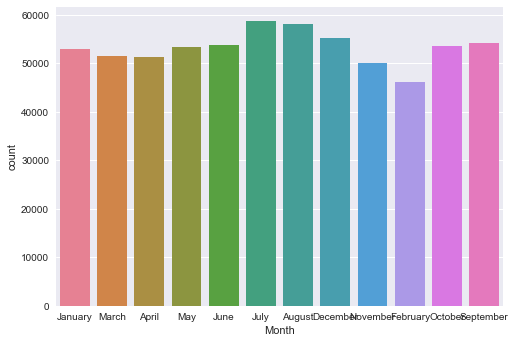

In [28]:

seaborn.countplot(x = 'Month', data=database_df, palette="husl")
seaborn.plt.show()


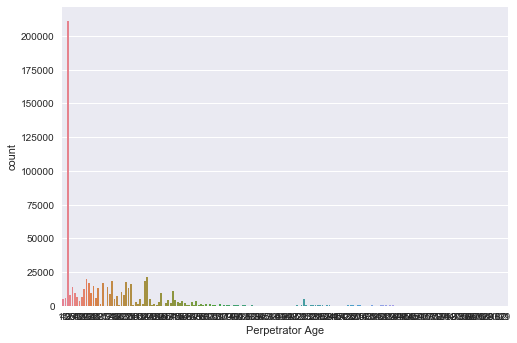

In [31]:
seaborn.countplot(x = 'Perpetrator Age', data=database_df, palette="husl")
seaborn.plt.show()


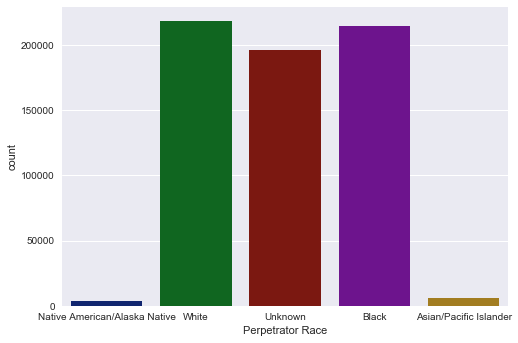

In [30]:
seaborn.countplot(x = 'Perpetrator Race', data=database_df, palette="dark")
seaborn.plt.show()

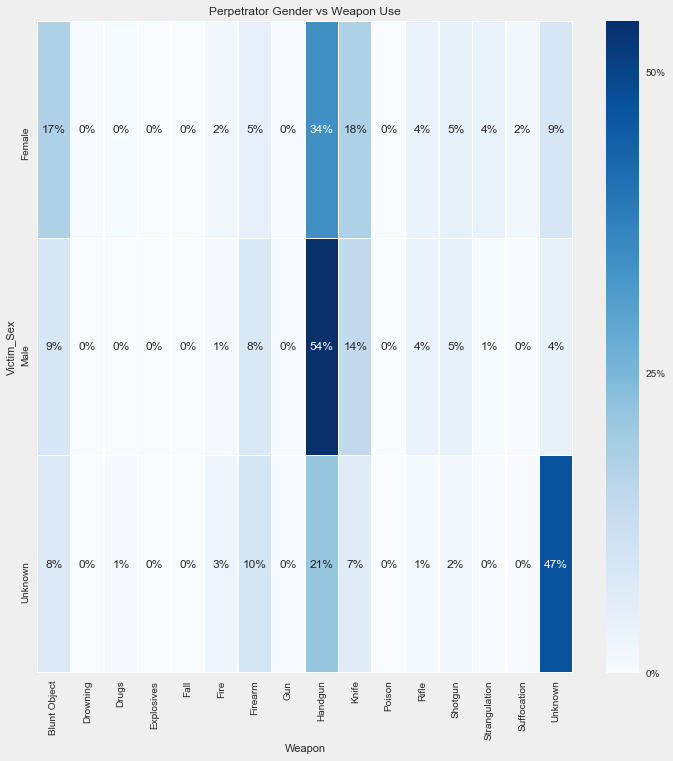

In [42]:


plt.figure(figsize=(12,12),facecolor='#efefef')
sns.set()
# ax.set_ticklabels(['0%', '20%', '75%', '100%'])
ax = sns.heatmap(pandas.crosstab(homicide.Victim_Sex,homicide.Weapon).apply(lambda r: r/r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5,cmap='Blues')
ax.set_title('Perpetrator Gender vs Weapon Use')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%',  '75%', '100%'])